In [1]:
import keras
keras.__version__
from keras.preprocessing import sequence
import pandas as pd
from keras.layers import Dense, Dropout, Activation, SimpleRNN, Embedding
from keras.models import Sequential
import numpy as np

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data = pd.read_csv('spam.csv',encoding='latin1')
data = data.iloc[:,0:2]
print(data.head(5))
print(data.shape)

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)


In [3]:
texts = data['v2'].values
temp = data['v1'].values
labels = []
for i in temp:
    if i=='ham':
        labels.append(0)
    else:
        labels.append(1)
labels = np.asarray(labels)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 500  # We will be training on 500 samples
validation_samples = 1000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
print(x_train.shape)
print(y_train.shape)
x_test=data[validation_samples:]
y_test=labels[validation_samples:]
print(x_test.shape)
print(y_test.shape)
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
print(x_val.shape)
print(y_val.shape)

Found 8920 unique tokens.
Shape of data tensor: (5572, 100)
Shape of label tensor: (5572,)
(500, 100)
(500,)
(4572, 100)
(4572,)
(1000, 100)
(1000,)


In [5]:
f = open('glove.6B/glove.6B.100d.txt')

embeddings_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [6]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [9]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 500 samples, validate on 1000 samples
Epoch 1/5
500/500 [==============================] - 0s 918us/step - loss: 0.2680 - acc: 0.8720 - val_loss: 0.1360 - val_acc: 0.9540
Epoch 2/5
500/500 [==============================] - 0s 218us/step - loss: 0.0798 - acc: 0.9800 - val_loss: 0.1574 - val_acc: 0.9500
Epoch 3/5
500/500 [==============================] - 0s 238us/step - loss: 0.0512 - acc: 0.9840 - val_loss: 0.1360 - val_acc: 0.9520
Epoch 4/5
500/500 [==============================] - 0s 220us/step - loss: 0.0270 - acc: 0.9920 - val_loss: 0.1185 - val_acc: 0.9520
Epoch 5/5
500/500 [==============================] - 0s 226us/step - loss: 0.0168 - acc: 1.0000 - val_loss: 0.1275 - val_acc: 0.9520


In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 1000 samples
Epoch 1/5
500/500 [==============================] - 0s 911us/step - loss: 0.3980 - a

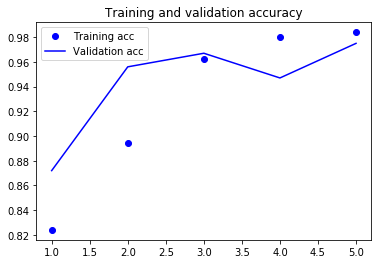

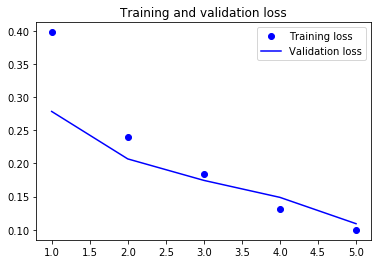

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model.evaluate(x_test, y_test)

4572/4572 [==============================] - 0s 58us/step


[0.11932621902133536, 0.9724409448818898]

In [14]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

4572/4572 [==============================] - 0s 54us/step


[0.14819045573609865, 0.9577865266841645]